# Datenvorbereitung für Data Mining Cup 2014
## Burk, Dau, Donner, Wesemann, Welsch
### Algorithmen: SVM und KNN

In [1]:
# import der bibliotheken

import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
# einlesen der zu bereinigenden Daten
df = pd.read_csv('data/orders_train.txt', delimiter=';')

# anzeigen der ersten 5 zeilen des datensatzes
df.head()

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment
0,1,2012-04-01,2012-04-03,186,m,denim,25,69.90,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,0
1,2,2012-04-01,2012-04-03,71,9+,ocher,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1
2,3,2012-04-01,2012-04-03,71,9+,curry,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1
3,4,2012-04-02,?,22,m,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,0
4,5,2012-04-02,1990-12-31,151,39,black,53,29.90,825,Mrs,1964-07-11,Rhineland-Palatinate,2011-02-16,0


**kommentar:**
wir sehen in zeile 4 (row_id = 3) einen fehlenden wert, also einen "missing value", welcher durch ein fragezeichen gekennzeichnet ist

In [3]:
# um zu prüfen, ob die missing values richtig gezählt werden, können wir die funktion df.info nutzen
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481092 entries, 0 to 481091
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   orderItemID     481092 non-null  int64  
 1   orderDate       481092 non-null  object 
 2   deliveryDate    481092 non-null  object 
 3   itemID          481092 non-null  int64  
 4   size            481092 non-null  object 
 5   color           481092 non-null  object 
 6   manufacturerID  481092 non-null  int64  
 7   price           481092 non-null  float64
 8   customerID      481092 non-null  int64  
 9   salutation      481092 non-null  object 
 10  dateOfBirth     481092 non-null  object 
 11  state           481092 non-null  object 
 12  creationDate    481092 non-null  object 
 13  returnShipment  481092 non-null  int64  
dtypes: float64(1), int64(5), object(8)
memory usage: 51.4+ MB


**kommentar:**
- uns fällt auf, dass zum einen alle spalten als "vollständig" markiert sind (non-null count = anzahl der gesamten zeilen) und zudem die datentypen für alle datumsspalten "falsch" sind.

**to-do:**
- anpassen der null-values
- anpassen der datentypen für datumsfelder

In [4]:
# als weitere funktion, um den datensatz zu beschreiben (also uns "mathematische größen" anzeigen zu lassen), probieren wir df.describe() aus
df.describe()

,orderItemID,itemID,manufacturerID,price,customerID,returnShipment
count,481092.00000,481092.000000,481092.000000,481092.000000,481092.000000,481092.000000
mean,240546.50000,1399.764779,29.726109,70.440229,33369.968376,0.482425
std,138879.44219,931.075227,30.064934,45.502854,23972.075259,0.499692
min,1.00000,1.000000,1.000000,0.000000,6.000000,0.000000
25%,120273.75000,332.000000,5.000000,34.900000,12891.000000,0.000000
50%,240546.50000,1569.000000,21.000000,59.900000,28426.000000,0.000000
75%,360819.25000,2342.000000,43.000000,89.900000,51141.000000,1.000000
max,481092.00000,3071.000000,166.000000,999.000000,86611.000000,1.000000


**kommentar:**
- die funktion df.describe() beschreibt nur für numerische spalten die anzahl, mittelwert, etc.
- irreführend ist hierbei die spalte "returnShipment", da diese laut vorgabe des datensatzes ein boolean sein sollte und damit lediglich die ausprägungen (0/1) besitzen sollte, sehen wir auch einen mittelwert für diese spalte

**to-do:**
- auch die spalte returnShipment muss vom datentyp her angepasst werden

# anpassung der null-values

In [5]:
# zählen der richtigen null-values:
# damit wir verstehen, wie viele null-values tatsächlich in den daten vorhanden sind, 
# schreiben wir eine eigene funktion, die die missing values ('?') zählt.

# achtung: df.info() zählt nur spezielle numpy NaN values, daher brauchen wir diese funktion

def count_actual_missing_values(initial_dataframe):
    qc_df = pd.DataFrame(columns=['field', 'missing_values'])

    for column in initial_dataframe:
        
        # berechne die anzahl von missing values pro spalte (definiert als '?' oder numpy.NaN)
        if (df[column]=='?').sum() is not None or df[column].isna().sum() is not None:
            missing_values = (df[column]=='?').sum() + df[column].isna().sum()
        else:
            missing_values = float('NaN')

        new_row = {'field': column, 'missing_values': missing_values}
        qc_df.loc[len(qc_df)] = new_row
        
    return qc_df

In [6]:
check_mv_df = count_actual_missing_values(df)
check_mv_df

,field,missing_values
0,orderItemID,0
1,orderDate,0
2,deliveryDate,39419
3,itemID,0
4,size,0
5,color,143
6,manufacturerID,0
7,price,0
8,customerID,0
9,salutation,0


**kommentar:**
- wir sehen, dass in den spalten 'deliveryDate', 'color' und 'dateOfBirth' missing values vorhanden sind
- schauen wir uns das zusatzmaterial (DMC 2014_documents/features.pdf) an, so sehen wir, dass sich die spalten mit fehlenden werten decken

**to-do:**
- wir wissen, dass die NaN werte nicht als numpy.NaN definiert sind, sondern als '?', dies wollen wir ändern

In [7]:
# mit der funktion replace() kann man werte in einem datensatz ersetzen
# in unserem fall ersetzen wir das '?' mit einem np.NaN value
df.replace('?', np.nan, inplace=True)

In [8]:
# nachdem wir das '?' ersetzt haben, gucken wir, ob die funktion info() jetzt das gewünsche ergebnis liefert
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481092 entries, 0 to 481091
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   orderItemID     481092 non-null  int64  
 1   orderDate       481092 non-null  object 
 2   deliveryDate    441673 non-null  object 
 3   itemID          481092 non-null  int64  
 4   size            481092 non-null  object 
 5   color           480949 non-null  object 
 6   manufacturerID  481092 non-null  int64  
 7   price           481092 non-null  float64
 8   customerID      481092 non-null  int64  
 9   salutation      481092 non-null  object 
 10  dateOfBirth     432203 non-null  object 
 11  state           481092 non-null  object 
 12  creationDate    481092 non-null  object 
 13  returnShipment  481092 non-null  int64  
dtypes: float64(1), int64(5), object(8)
memory usage: 51.4+ MB


**kommentar:**
- wir sehen, dass unser "suchen und ersetzen" funktioniert hat und wir nun die "richtigen" missing-values aufgelistet bekommen

In [9]:
# der datensatz hat sich jetzt entsprechen verändert - in zeile 4 (index=3) sehen wir den NaN value
df.head()

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment
0,1,2012-04-01,2012-04-03,186,m,denim,25,69.90,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,0
1,2,2012-04-01,2012-04-03,71,9+,ocher,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1
2,3,2012-04-01,2012-04-03,71,9+,curry,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1
3,4,2012-04-02,NaN,22,m,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,0
4,5,2012-04-02,1990-12-31,151,39,black,53,29.90,825,Mrs,1964-07-11,Rhineland-Palatinate,2011-02-16,0


**erledigtes to-do:**
- missing values werden richtig gezählt

# anpassung der datentypen für datumsfelder

In [10]:
# an dieser stelle erhalten wir einen out of bounds fehler für den datentyp datetime:

"""
# wir versuchen die datumsfelder mittels der pandas function to_datetime() zu konvertieren
# hierfür benötigen wir die .apply() function um die typkonvertierung anzuwenden

df[['orderDate', 'deliveryDate', 'dateOfBirth', 'creationDate']] = \
df[['orderDate', 'deliveryDate', 'dateOfBirth', 'creationDate']].apply(pd.to_datetime, format='%Y-%m-%d')
"""

"\n# wir versuchen die datumsfelder mittels der pandas function to_datetime() zu konvertieren\n# hierfür benötigen wir die .apply() function um die typkonvertierung anzuwenden\n\ndf[['orderDate', 'deliveryDate', 'dateOfBirth', 'creationDate']] = df[['orderDate', 'deliveryDate', 'dateOfBirth', 'creationDate']].apply(pd.to_datetime, format='%Y-%m-%d')\n"

**kommentar:**
- als fehlermeldung erhalten wir eine OutOfBounds-Exception mit dem hinweis darauf, dass der timestamp '1655-04-19' nicht in der datetime range liegt
- das angegebene datum ist fachlich anzuzweifeln, da es vermutlich keine order, delivery, creation oder geburtsdatum gibt, welches im jahr 1655 liegt

In [11]:
# wir wollen uns zunächst anschauen, welchen datumsbereich der pandas timestamp abdecken kann
# hierfür verwenden wir die interne function .min und .max
min_ts = pd.Timestamp.min
max_ts = pd.Timestamp.max
print(f'min timestamp: {min_ts}, max timestamp: {max_ts}')

min timestamp: 1677-09-21 00:12:43.145224193, max timestamp: 2262-04-11 23:47:16.854775807


**kommentar:**
- wir sehen, dass das jahr 1655 außerhalb der kleinsten ausprägung von timestamp (1677) liegt

**to-do:**
- betrachten der betroffenen datensätze

In [12]:
# mit einer regular expression (mit welcher man strings maskieren kann) und der funktion df.query() können wir alle datensätze abfragen,
# die ein dateOfBirth aus dem Jahr 1600 haben
df.query("dateOfBirth.str.contains('16\d\d-\d\d-\d\d', na=False, regex=True)")

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment
201497,201498,2012-09-12,2012-09-13,1662,l,brown,36,109.9,48469,Mrs,1655-04-19,Bavaria,2011-02-16,1
223802,223803,2012-09-22,2012-09-24,1662,m,brown,36,109.9,48469,Mrs,1655-04-19,Bavaria,2011-02-16,1
322553,322554,2013-01-08,2013-01-31,2429,M,black,11,89.9,48469,Mrs,1655-04-19,Bavaria,2011-02-16,0


In [13]:
# mit einer regular expression (mit welcher man strings maskieren kann) und der funktion df.query() können wir alle datensätze abfragen,
# die ein dateOfBirth aus dem Jahr 1700 haben
df.query("dateOfBirth.str.contains('17\d\d-\d\d-\d\d', na=False, regex=True)")

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment


In [14]:
# mit einer regular expression (mit welcher man strings maskieren kann) und der funktion df.query() können wir alle datensätze abfragen,
# die ein dateOfBirth aus dem Jahr 1800 haben
df.query("dateOfBirth.str.contains('18\d\d-\d\d-\d\d', na=False, regex=True)")

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment


In [15]:
# mit einer regular expression (mit welcher man strings maskieren kann) und der funktion df.query() können wir alle datensätze abfragen,
# die ein dateOfBirth aus dem Jahr 1900 haben
df.query("dateOfBirth.str.contains('19\d\d-\d\d-\d\d', na=False, regex=True)")

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment
0,1,2012-04-01,2012-04-03,186,m,denim,25,69.90,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,0
1,2,2012-04-01,2012-04-03,71,9+,ocher,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1
2,3,2012-04-01,2012-04-03,71,9+,curry,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1
3,4,2012-04-02,NaN,22,m,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,0
4,5,2012-04-02,1990-12-31,151,39,black,53,29.90,825,Mrs,1964-07-11,Rhineland-Palatinate,2011-02-16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481086,481087,2013-03-31,2013-04-09,2561,39,blue,1,139.90,7032,Mr,1962-12-17,Lower Saxony,2011-03-12,1
481087,481088,2013-03-31,2013-04-09,2561,39+,blue,1,139.90,7032,Mr,1962-12-17,Lower Saxony,2011-03-12,1
481089,481090,2013-03-31,1990-12-31,2458,XXL,black,5,99.90,86611,Mr,1973-05-16,Berlin,2013-03-31,0
481090,481091,2013-03-31,1990-12-31,2659,XXL,black,49,99.90,86611,Mr,1973-05-16,Berlin,2013-03-31,0


In [16]:
# mit einer regular expression (mit welcher man strings maskieren kann) und der funktion df.query() können wir alle datensätze abfragen,
# die ein dateOfBirth aus dem Jahr 2000 haben
df.query("dateOfBirth.str.contains('20\d\d-\d\d-\d\d', na=False, regex=True)")

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment
6495,6496,2012-04-06,2012-04-09,199,39,white,4,69.95,3941,Mrs,2010-08-03,Lower Saxony,2011-02-16,0
6496,6497,2012-04-06,2012-06-19,62,unsized,green,5,14.90,3941,Mrs,2010-08-03,Lower Saxony,2011-02-16,0
6497,6498,2012-04-06,2012-06-19,158,38,green,54,59.90,3941,Mrs,2010-08-03,Lower Saxony,2011-02-16,1
20584,20585,2012-04-15,2012-04-19,96,xxl,blau,3,16.90,9222,Mrs,2011-04-11,Bavaria,2011-05-23,0
20585,20586,2012-04-15,2012-04-19,96,xxl,green,3,16.90,9222,Mrs,2011-04-11,Bavaria,2011-05-23,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440654,440655,2013-03-10,2013-03-12,2382,M,terracotta,3,49.90,49402,Mrs,2011-10-18,Lower Saxony,2013-03-10,1
464390,464391,2013-03-22,NaN,2869,43,black,1,149.90,84668,Mrs,2012-11-18,Baden-Wuerttemberg,2013-03-22,0
464391,464392,2013-03-22,NaN,2552,4+,blue,19,89.90,84668,Mrs,2012-11-18,Baden-Wuerttemberg,2013-03-22,0
465941,465942,2013-03-23,2013-04-01,2552,5+,blue,19,89.90,84668,Mrs,2012-11-18,Baden-Wuerttemberg,2013-03-22,1


In [17]:
# mit einer regular expression (mit welcher man strings maskieren kann) und der funktion df.query() können wir alle datensätze abfragen,
# die ein dateOfBirth aus dem Jahr 2100 haben
df.query("dateOfBirth.str.contains('21\d\d-\d\d-\d\d', na=False, regex=True)")

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment


**kommentar:**
- wir haben uns alle jahrhunderte von 1600 - 2100 angeschaut, um ein gefühl dafür zu bekommen, in welchen "clustern" wir ausreißer finden
- im 16. jahrhundert haben wir drei datensätze identifizieren können, die wir aufgrund der datenmenge von etwa 500.000 löschen werden

**to-do:**
- datensätze aus 1600 löschen

In [18]:
# hier definieren wir ein pattern (muster), welches wir anschließend als maske verwenden, um die datensätze zu identifizieren, die wir löschen
pattern = r'16\d\d-\d\d-\d\d'

# hier wenden wir das pattern auf der spalte dateOfBirth an
mask = df['dateOfBirth'].str.contains(pattern, na=False)

# mit dem ~ operator können wir die maske auf dem gesamten datensatz löschen
df = df[~mask]

In [19]:
df.query("dateOfBirth.str.contains('16\d\d-\d\d-\d\d', na=False, regex=True)")

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment


**kommentar:**
- wir haben nun alle zeilen gelöscht, die aus dem 16. jahrhundert vorhanden waren
- jetzt haben wir die möglichkeit den datentyp von object auf datetime zu ändern, um später damit besser rechnen zu können

**to-do:**
- datentyp für alle datumsfelder anpassen

In [20]:
# diese funktion haben wir bereits versucht vorne zu verwenden, jedoch ohne erfolg, da 1655 out of bounds war
# da wir nun die entsprechenden fehlerhaften zeilen gelöscht haben, können wir die funktion erneut ausführen

df[['orderDate', 'deliveryDate', 'dateOfBirth', 'creationDate']] = \
df[['orderDate', 'deliveryDate', 'dateOfBirth', 'creationDate']].apply(pd.to_datetime, format='%Y-%m-%d')

**kommentar:**
- nachdem wir nun den datentyp angepasst haben, wollen wir das ergebnis validieren

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 481089 entries, 0 to 481091
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   orderItemID     481089 non-null  int64         
 1   orderDate       481089 non-null  datetime64[ns]
 2   deliveryDate    441670 non-null  datetime64[ns]
 3   itemID          481089 non-null  int64         
 4   size            481089 non-null  object        
 5   color           480946 non-null  object        
 6   manufacturerID  481089 non-null  int64         
 7   price           481089 non-null  float64       
 8   customerID      481089 non-null  int64         
 9   salutation      481089 non-null  object        
 10  dateOfBirth     432200 non-null  datetime64[ns]
 11  state           481089 non-null  object        
 12  creationDate    481089 non-null  datetime64[ns]
 13  returnShipment  481089 non-null  int64         
dtypes: datetime64[ns](4), float64(1), in

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 481089 entries, 0 to 481091
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   orderItemID     481089 non-null  int64         
 1   orderDate       481089 non-null  datetime64[ns]
 2   deliveryDate    441670 non-null  datetime64[ns]
 3   itemID          481089 non-null  int64         
 4   size            481089 non-null  object        
 5   color           480946 non-null  object        
 6   manufacturerID  481089 non-null  int64         
 7   price           481089 non-null  float64       
 8   customerID      481089 non-null  int64         
 9   salutation      481089 non-null  object        
 10  dateOfBirth     432200 non-null  datetime64[ns]
 11  state           481089 non-null  object        
 12  creationDate    481089 non-null  datetime64[ns]
 13  returnShipment  481089 non-null  int64         
dtypes: datetime64[ns](4), float64(1), in

In [23]:
# anpassung des datentyps int auf bool bei der spalte returnShipment

df['returnShipment'] = df['returnShipment'].astype(bool)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 481089 entries, 0 to 481091
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   orderItemID     481089 non-null  int64         
 1   orderDate       481089 non-null  datetime64[ns]
 2   deliveryDate    441670 non-null  datetime64[ns]
 3   itemID          481089 non-null  int64         
 4   size            481089 non-null  object        
 5   color           480946 non-null  object        
 6   manufacturerID  481089 non-null  int64         
 7   price           481089 non-null  float64       
 8   customerID      481089 non-null  int64         
 9   salutation      481089 non-null  object        
 10  dateOfBirth     432200 non-null  datetime64[ns]
 11  state           481089 non-null  object        
 12  creationDate    481089 non-null  datetime64[ns]
 13  returnShipment  481089 non-null  bool          
dtypes: bool(1), datetime64[ns](4), float

**kommentar:**
- nachdem wir die fehlerhaften datensätze aus dem 16. jahrhundert gelöscht haben, wollen wir die weiteren unplausiblen datumsangaben untersuchen
- hierfür extrahieren wir das alter zum zeitpunkt der bestellung, indem wir das orderDate-dateOfBirth berechnen

**to-do:**
- feature engineering "age_at_order"

In [24]:
df['age_at_order'] = (df['orderDate'] - df['dateOfBirth']) / pd.Timedelta(days=365)
df.head()

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment,age_at_order
0,1,2012-04-01,2012-04-03,186,m,denim,25,69.90,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,False,47.265753
1,2,2012-04-01,2012-04-03,71,9+,ocher,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,True,47.265753
2,3,2012-04-01,2012-04-03,71,9+,curry,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,True,47.265753
3,4,2012-04-02,NaT,22,m,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,False,52.432877
4,5,2012-04-02,1990-12-31,151,39,black,53,29.90,825,Mrs,1964-07-11,Rhineland-Palatinate,2011-02-16,False,47.758904


In [25]:
df.drop(df.loc[df['age_at_order']<7].index, inplace=True)
df.drop(df.loc[df['age_at_order']>=110].index, inplace=True)
df.drop(columns=['dateOfBirth'])

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,state,creationDate,returnShipment,age_at_order
0,1,2012-04-01,2012-04-03,186,m,denim,25,69.90,794,Mrs,Baden-Wuerttemberg,2011-04-25,False,47.265753
1,2,2012-04-01,2012-04-03,71,9+,ocher,21,69.95,794,Mrs,Baden-Wuerttemberg,2011-04-25,True,47.265753
2,3,2012-04-01,2012-04-03,71,9+,curry,21,69.95,794,Mrs,Baden-Wuerttemberg,2011-04-25,True,47.265753
3,4,2012-04-02,NaT,22,m,green,14,39.90,808,Mrs,Saxony,2012-01-04,False,52.432877
4,5,2012-04-02,1990-12-31,151,39,black,53,29.90,825,Mrs,Rhineland-Palatinate,2011-02-16,False,47.758904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481087,481088,2013-03-31,2013-04-09,2561,39+,blue,1,139.90,7032,Mr,Lower Saxony,2011-03-12,True,50.320548
481088,481089,2013-03-31,2013-04-02,2669,39,grey,18,130.00,86610,Mrs,Berlin,2012-03-24,False,NaN
481089,481090,2013-03-31,1990-12-31,2458,XXL,black,5,99.90,86611,Mr,Berlin,2013-03-31,False,39.901370
481090,481091,2013-03-31,1990-12-31,2659,XXL,black,49,99.90,86611,Mr,Berlin,2013-03-31,False,39.901370


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 475719 entries, 0 to 481091
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   orderItemID     475719 non-null  int64         
 1   orderDate       475719 non-null  datetime64[ns]
 2   deliveryDate    436682 non-null  datetime64[ns]
 3   itemID          475719 non-null  int64         
 4   size            475719 non-null  object        
 5   color           475577 non-null  object        
 6   manufacturerID  475719 non-null  int64         
 7   price           475719 non-null  float64       
 8   customerID      475719 non-null  int64         
 9   salutation      475719 non-null  object        
 10  dateOfBirth     426830 non-null  datetime64[ns]
 11  state           475719 non-null  object        
 12  creationDate    475719 non-null  datetime64[ns]
 13  returnShipment  475719 non-null  bool          
 14  age_at_order    426830 non-null  flo

**kommentar:**
- nachdem wir nun ein neues feature entwickelt haben, schauen wir uns die spalte "price" an
- zunächst betrachten wir die verteilung der werte

**to-do:**
- query auswertung der spalte "price"
- grafische auswertung (zb boxplot) der spalte "price"

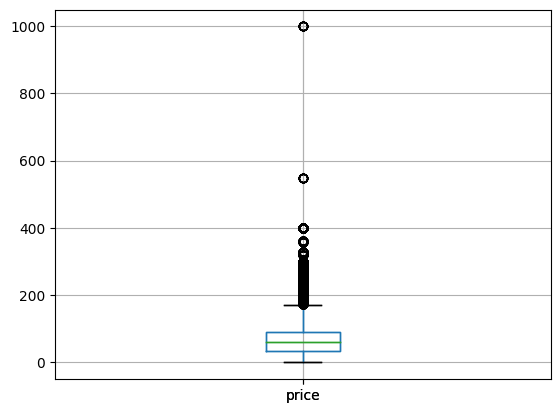

In [31]:
# um eine ausreißeranalyse durchzuführen, schauen wir uns zunächst einen boxplot an
df.boxplot(column='price')
plt.show()

In [56]:
df[(df['price'] >= 180)]

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment,age_at_order
15,16,2012-04-02,2012-04-04,605,43,anthracite,1,199.90,860,Mrs,1963-08-15,North Rhine-Westphalia,2011-03-20,False,48.665753
593,594,2012-04-03,2012-04-04,682,41,brown,54,189.90,1336,Mrs,1976-08-01,Brandenburg,2011-08-26,False,35.695890
772,773,2012-04-01,2012-04-05,641,M,black,48,199.95,1423,Mrs,1944-10-26,North Rhine-Westphalia,2012-04-01,False,67.476712
821,822,2012-04-03,2012-04-04,701,M,anthracite,75,199.90,1453,Mrs,1964-03-11,Lower Saxony,2011-02-16,False,48.095890
1366,1367,2012-04-01,2012-04-04,738,11+,grey,80,200.00,1733,Mrs,1966-06-05,Rhineland-Palatinate,2011-02-16,False,45.854795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479952,479953,2013-03-31,2013-05-01,2974,39,stained,55,189.00,86401,Mrs,1959-05-25,Thuringia,2013-03-31,True,53.887671
479958,479959,2013-03-31,2013-04-03,2710,39,black,55,189.00,86404,Mrs,NaT,Baden-Wuerttemberg,2013-03-31,False,NaN
480095,480096,2013-03-31,2013-04-02,2500,38,red,101,249.90,38189,Mrs,1966-03-29,Brandenburg,2011-04-24,True,47.038356
480570,480571,2013-03-31,2013-04-03,2775,40,grey,1,199.90,86492,Mrs,1963-05-29,Baden-Wuerttemberg,2013-03-31,False,49.873973


In [27]:
df[(df['price'] == 0)]

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment,age_at_order
65,66,2012-04-02,2012-04-24,239,unsized,brown,60,0.0,925,Mrs,1958-05-08,Hesse,2011-03-16,False,53.939726
71,72,2012-04-02,2012-04-16,553,unsized,green,86,0.0,937,Mrs,1955-09-12,Hesse,2012-03-03,False,56.594521
986,987,2012-04-03,2012-04-26,239,unsized,brown,60,0.0,1543,Mrs,1962-08-14,Baden-Wuerttemberg,2011-11-05,False,49.671233
1250,1251,2012-04-03,NaT,157,unsized,purple,32,0.0,1687,Mrs,NaT,North Rhine-Westphalia,2012-04-02,False,NaN
1673,1674,2012-04-04,2012-04-05,62,unsized,white,5,0.0,1848,Mrs,1957-11-02,Baden-Wuerttemberg,2011-02-16,False,54.457534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480659,480660,2013-03-31,2013-04-03,3069,unsized,black,157,0.0,13871,Mrs,NaT,North Rhine-Westphalia,2012-04-23,False,NaN
480689,480690,2013-03-31,2013-04-03,3069,unsized,black,157,0.0,51305,Mrs,1961-03-11,Baden-Wuerttemberg,2012-09-19,False,52.090411
480705,480706,2013-03-31,2013-04-03,3069,unsized,black,157,0.0,16759,Mrs,1965-09-04,Brandenburg,2011-02-16,False,47.602740
480847,480848,2013-03-31,2013-04-03,3069,unsized,black,157,0.0,34356,Mrs,1949-11-19,North Rhine-Westphalia,2011-05-01,False,63.405479


In [52]:
df['size'] = df['size'].str.upper()
id_counts = df['size'].value_counts()
result_df = pd.DataFrame({'size': id_counts.index, 'count': id_counts.values})
result_df.to_csv('output_files/size_counts.csv', index=False)